# Analysis of the Weekly Atmospheric CO₂ Concentration at Mauna Loa

## Context

In 1958, Charles David Keeling began continuous measurements of atmospheric CO₂ concentration at the Mauna Loa Observatory in Hawaii. These measurements revealed a strong seasonal cycle and a long-term increasing trend. The dataset is a cornerstone of climate science and empirical
time series analysis.

The main purpose of this notebook is to study the temporal structure of the CO₂ concentration over time, study its main components like the seasonal patterns and the long-term trends, fit a model, use it to make predictions and validate using future observations.

## Data source and reproducibility information

- **Data source**: https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html
- **Dataset**: Primary Mauna Loa atmospheric CO₂ record 
- **File used**: `weekly_in_situ_co2_mlo.csv`
- **Download date**: *2026-01-01*

<!-- According to the data documentation, missing values are encoded using the value `-99.99`. -->

## Data loading
In a first step, we load the CO₂ weekly observations dataset from a local CSV file stored in the repository, and we inspect its structure. When reading the file, we ignore the metadata lines and keep only the date (middle day of each weekly period) and the co2_ppm (weekly averaged baseline CO₂ concentration) columns.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import date

In [8]:
DOWNLOAD_DATE = date.today().isoformat()
print("Notebook run date:", DOWNLOAD_DATE)

Notebook run date: 2026-02-11


In [9]:
DATA_PATH = Path("data/weekly_in_situ_co2_mlo.csv")

df = pd.read_csv(
    DATA_PATH,
    comment='"',
    header=None,
    names=["date", "co2_ppm"],
)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["co2_ppm"] = pd.to_numeric(df["co2_ppm"], errors="coerce")

df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print("Shape:", df.shape)
df.head()

Shape: (3457, 2)


,date,co2_ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


## Quick Data exploration
Before modeling, we do some exploration of the data by checking the time coverage, missing values, the typical sampling interval (weekly), and a first plot of the raw series.

In [10]:
print("Date range:", df["date"].min(), "→", df["date"].max())
print("Missing CO2 values:", df["co2_ppm"].isna().sum())

df["co2_ppm"].describe()

Date range: 1958-03-29 00:00:00 → 2025-11-29 00:00:00
Missing CO2 values: 0


count    3457.000000
mean      360.980304
std        32.585174
min       313.040000
25%       331.940000
50%       356.210000
75%       386.910000
max       430.500000
Name: co2_ppm, dtype: float64

In [11]:
delta_days = df["date"].diff().dt.days
delta_days.value_counts().head(10)

date
7.0      3425
14.0       18
21.0        6
28.0        2
35.0        2
42.0        1
63.0        1
133.0       1
Name: count, dtype: int64

The series contains a few missing weekly timestamps (gaps larger than 7 days). We will later use methods robust to occasional missing weeks.

## Superposition of seasonal oscillation and long-term trend
<!-- The weekly CO₂ series clearly shows a periodic seasonal oscillation superimposed on a long-term increase.
To make the slow component visible, we add a smoothed curve computed with a centered moving average over one year (≈ 52 weeks). -->

We then plot the raw CO₂ concentration time series, without applying any filtering or smoothing. This first plot allows us to identify the main temporal structures present in the data.

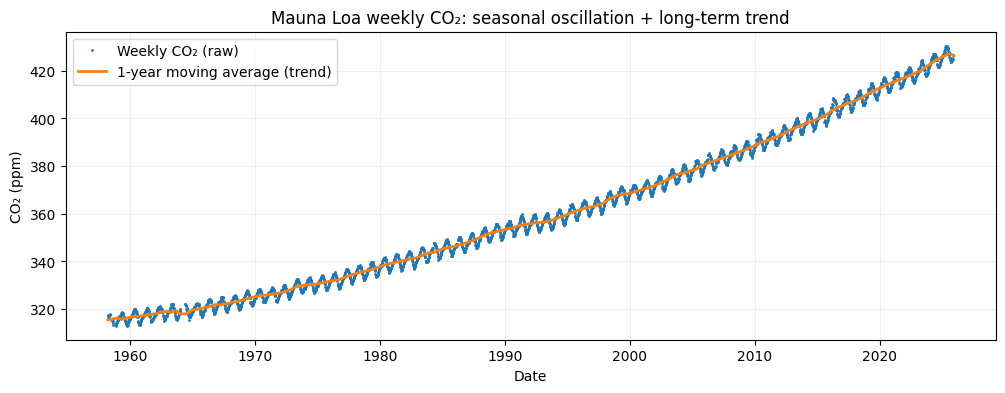

In [34]:
# plt.figure(figsize=(12,4))
# plt.plot(df["date"], df["co2_ppm"], ".", markersize=2)
# plt.title("Mauna Loa weekly CO₂ concentration (raw)")
# plt.xlabel("Date")
# plt.ylabel("CO₂ (ppm)")
# plt.grid(True, alpha=0.2)
# plt.show()

df = df.copy()

df["trend_52w"] = (
    df["co2_ppm"]
    .rolling(window=52, center=True, min_periods=26)
    .mean()
)

plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["co2_ppm"], ".", markersize=2, label="Weekly CO₂ (raw)")
plt.plot(df["date"], df["trend_52w"], linewidth=2, label="1-year moving average (trend)")
plt.title("Mauna Loa weekly CO₂: seasonal oscillation + long-term trend")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

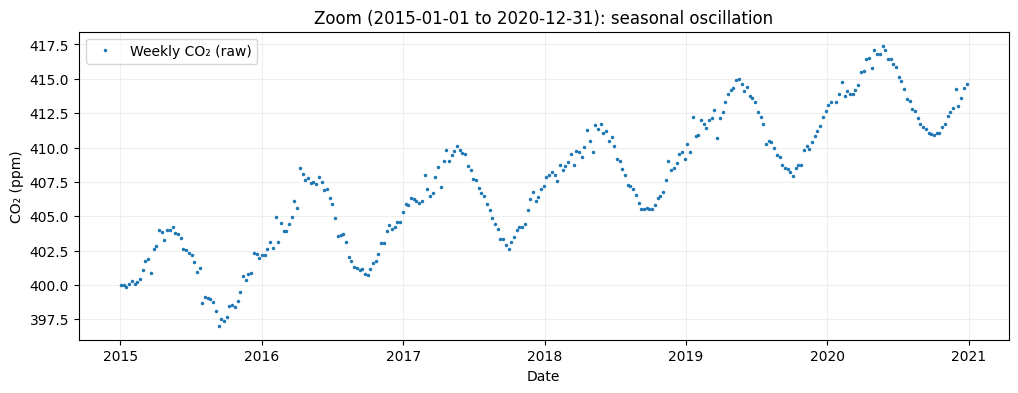

In [36]:
start, end = "2015-01-01", "2020-12-31"
mask = (df["date"] >= start) & (df["date"] <= end)

plt.figure(figsize=(12,4))
plt.plot(df.loc[mask, "date"], df.loc[mask, "co2_ppm"], ".", markersize=3, label="Weekly CO₂ (raw)")
plt.title(f"Zoom ({start} to {end}): seasonal oscillation")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

The CO₂ record from 1958 to today shows a clear long-term increasing trend in atmospheric CO₂ concentration. The curve also shows a regular yearly oscillation. This visual suggests that the displayed signal is the superposition of a slow systematic evolution with a repeating seasonal cycle.

## Data completeness: detecting missing weeks
Some weekly timestamp values are missing in the dataset. To quantify this, we first compute the difference between consecutive observations to identify gaps exceeding 7 days, then we align the series onto a strict weekly grid (Saturday-based) so that missing weeks show up explicitly as NaN values.

In [15]:
delta_days = df["date"].diff().dt.days
gaps = df.loc[delta_days > 7, ["date"]].copy()
gaps["gap_days"] = delta_days[delta_days > 7].values
gaps = gaps.rename(columns={"date": "date_after_gap"})

print(f"Number of gaps > 7 days: {len(gaps)}")
gaps.sort_values("gap_days", ascending=False).head(10)


Number of gaps > 7 days: 31


,date_after_gap,gap_days
278,1964-05-30,133.0
17,1958-11-08,63.0
8,1958-07-05,42.0
2386,2005-03-26,35.0
1303,1984-04-28,35.0
211,1962-09-15,28.0
386,1966-08-06,28.0
3303,2022-12-17,21.0
2316,2003-10-25,21.0
2432,2006-02-25,21.0


The time differences confirm that most observations are spaced by 7 days, but a small number of larger gaps exist (missing weeks). 

In [16]:
ts = df.set_index("date")["co2_ppm"].sort_index()

ts_weekly = ts.asfreq("W-SAT")

print("Original rows:", len(ts))
print("Regular weekly rows:", len(ts_weekly))
print("Missing weeks after regularization (NaN):", int(ts_weekly.isna().sum()))

ts_weekly.head(10)

Original rows: 3457
Regular weekly rows: 3532
Missing weeks after regularization (NaN): 75


date
1958-03-29    316.19
1958-04-05    317.31
1958-04-12    317.69
1958-04-19    317.58
1958-04-26    316.48
1958-05-03    316.95
1958-05-10       NaN
1958-05-17    317.56
1958-05-24    317.99
1958-05-31       NaN
Freq: W-SAT, Name: co2_ppm, dtype: float64

<!-- For methods requiring continuity (like STL), we will fill only small gaps using limited interpolation. -->

After converting to a regular weekly index, the series contains 75 missing weekly timestamps appearing as NaN values. We keep this information (ts_weekly) for the next steps: decomposition and modeling. 
<!-- will either use methods robust to occasional missing weeks or apply limited interpolation only when necessary. -->

## STL Decomposition
To separate the slow long-term increase from the yearly seasonal oscillation, we apply STL decomposition (Seasonal-Trend decomposition using Loess) and because the data are weekly, we use a seasonal period of 52 weeks (≈ 1 year). We work on the weekly series ts_weekly since STL requires a regular time index. Also, we fill only small gaps using limited interpolation to avoid distorting the signal.

Length used for STL: 3513
Remaining NaNs: 0


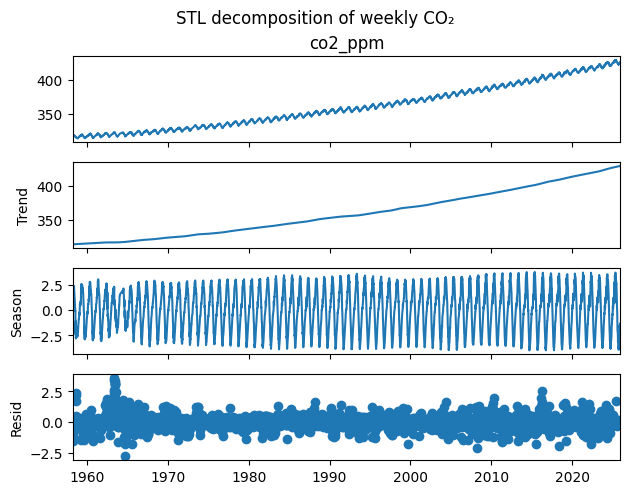

In [23]:
from statsmodels.tsa.seasonal import STL
ts_filled = ts_weekly.interpolate(limit=4)

ts_stl = ts_filled.dropna()

print("Length used for STL:", len(ts_stl))
print("Remaining NaNs:", int(ts_stl.isna().sum()))

stl = STL(ts_stl, period=52, robust=True)
res = stl.fit()

trend = res.trend
seasonal = res.seasonal
residual = res.resid

res.plot()
plt.suptitle("STL decomposition of weekly CO₂", y=1.02)
plt.show()

In [24]:
decomp = pd.DataFrame({
    "co2_ppm": ts_stl,
    "trend": trend,
    "seasonal": seasonal,
    "residual": residual
})

decomp.head()

,co2_ppm,trend,seasonal,residual
date,,,,
1958-03-29,316.19,315.439230,2.333550,-1.582780
1958-04-05,317.31,315.452584,2.303374,-0.445957
1958-04-12,317.69,315.465919,2.220980,0.003100
1958-04-19,317.58,315.479237,2.135281,-0.034518
1958-04-26,316.48,315.492537,2.220353,-1.232890


As we can see in plot, the STL decomposition separates the weekly CO₂ series into a smooth upward **long-term increase trend**, a **regular** seasonal component with an **annual** period (≈52 weeks), and **residuals** that reflect short-term variability and noise This confirms that the observed signal is well explained by the superposition of a slow evolution and a yearly cycle.

## Seasonal cycle analysis (amplitude and phase)
From the STL seasonal component, we estimate the seasonal amplitude (peak-to-trough <in ppm) and the typical timing of the peak and trough within the year. We also compute the seasonal amplitude per year to check whether it changes over time.

In [28]:
seasonal = decomp["seasonal"]

amp_overall = seasonal.max() - seasonal.min()
print(f"Overall seasonal amplitude (peak-to-trough): {amp_overall:.2f} ppm")

seasonal_cycle = seasonal.groupby(seasonal.index.isocalendar().week).mean()
peak_week = int(seasonal_cycle.idxmax())
trough_week = int(seasonal_cycle.idxmin())
print("Typical peak week-of-year:", peak_week)
print("Typical trough week-of-year:", trough_week)

Overall seasonal amplitude (peak-to-trough): 7.74 ppm
Typical peak week-of-year: 19
Typical trough week-of-year: 40


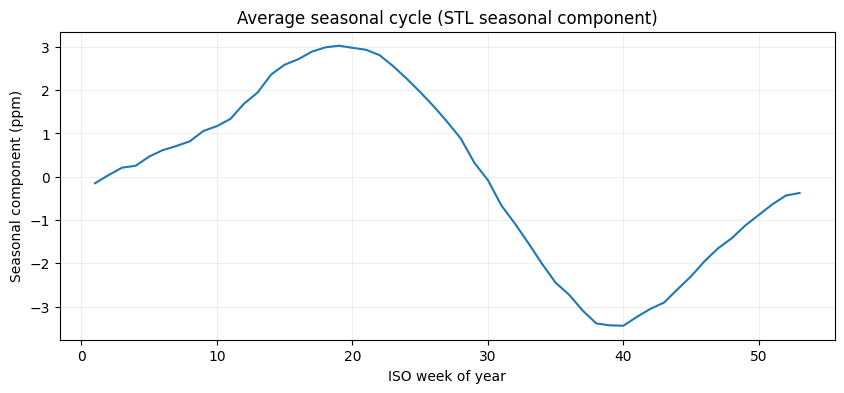

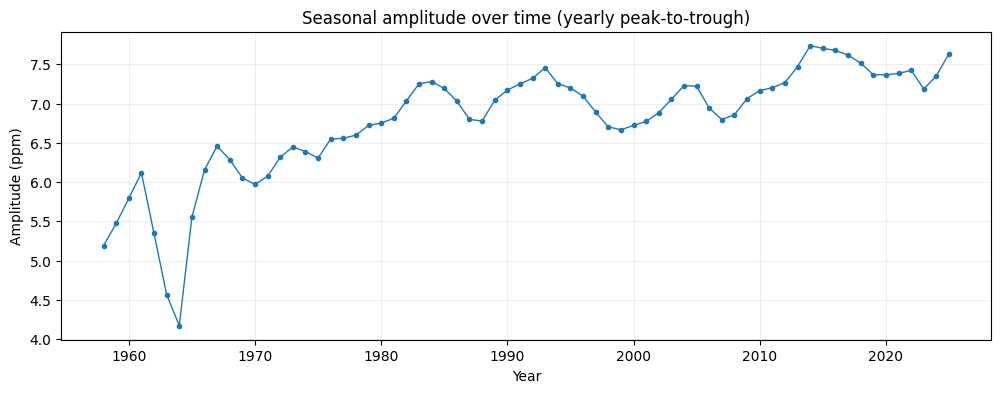

In [29]:
amp_by_year = seasonal.groupby(seasonal.index.year).apply(lambda s: s.max() - s.min())

plt.figure(figsize=(10,4))
plt.plot(seasonal_cycle.index, seasonal_cycle.values)
plt.title("Average seasonal cycle (STL seasonal component)")
plt.xlabel("ISO week of year")
plt.ylabel("Seasonal component (ppm)")
plt.grid(True, alpha=0.2)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(amp_by_year.index, amp_by_year.values, marker=".", linewidth=1)
plt.title("Seasonal amplitude over time (yearly peak-to-trough)")
plt.xlabel("Year")
plt.ylabel("Amplitude (ppm)")
plt.grid(True, alpha=0.2)
plt.show()

We can conclude from this analysis that the STL seasonal component shows a clear and repeatable annual cycle with an overall peak-to-trough amplitude of about **7.74 ppm**: on average, the seasonal signal reaches its maximum around **week 19** and its minimum around **week 40** of the year. The year-by-year peak-to-trough visual plot suggests that this seasonal amplitude is not perfectly constant and reveals an increase over time, with some interannual variability. This indicates that the strength of the seasonal CO₂ swing has slightly intensified over time.

## Modeling the long-term trend on the full data (fit + parameters)
To describe the long-term increase in atmospheric CO₂, we fit a simple model to the trend component extracted by STL.
We test a linear trend (constant growth rate). The fitted parameters are reported, and the fitted curves are compared to the STL trend.

In [37]:
trend = decomp["trend"].dropna()

t_years = trend.index.year + (trend.index.dayofyear - 1) / 365.25
t0 = t_years.min()
x = t_years - t0  # years since start

y = trend.values
print("Trend series length:", len(y))
print("Time range:", trend.index.min().date(), "→", trend.index.max().date())

Trend series length: 3513
Time range: 1958-03-29 → 2025-11-29


t0 = 1958.2382 years
a = 304.279 ppm
b = 1.659 ppm/year
RMSE = 4.686 ppm


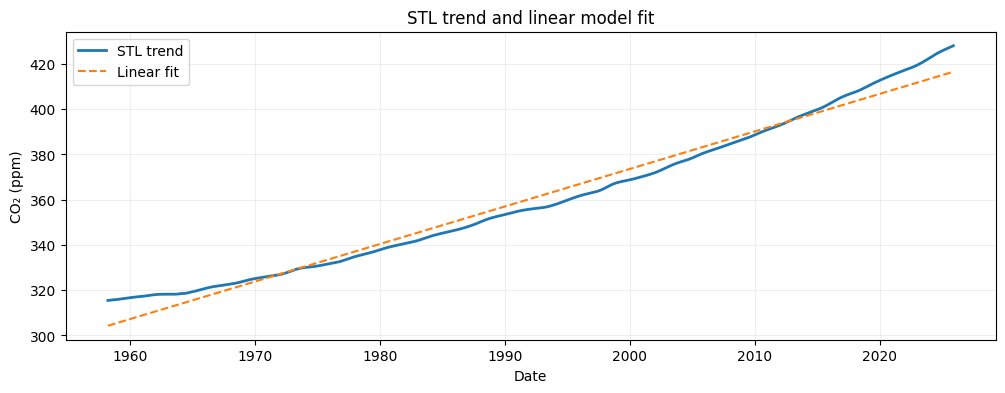

In [38]:
b, a = np.polyfit(x, y, deg=1)
yhat = a + b * x

rmse = np.sqrt(np.mean((y - yhat) ** 2))

print(f"t0 = {t0:.4f} years")
print(f"a = {a:.3f} ppm")
print(f"b = {b:.3f} ppm/year")
print(f"RMSE = {rmse:.3f} ppm")

plt.figure(figsize=(12,4))
plt.plot(trend.index, y, linewidth=2, label="STL trend")
plt.plot(trend.index, yhat, linestyle="--", label="Linear fit")
plt.title("STL trend and linear model fit")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

The linear model estimates an average increase of about **1.66 ppm** per year (slope 𝑏=1.659), capturing the overall rise in the STL trend but, the visible departures between the fitted line and the STL trend, especially in the later decades, show that the growth rate is not perfectly constant over time (the increase accelerates), which is consistent with the relatively large error (**RMSE ≈ 4.69 ppm**) and indicates that a linear model is only a rough first-order approximation of the long-term evolution.

## Fit a model up to 2015, Forecast to 2025 and Validate
We refit the linear model on data up to 2015, then extrapolate to 2025 and compare predictions to the observed trend.

In [39]:
trend = decomp["trend"].dropna()

cutoff = pd.Timestamp("2015-12-31")

train = trend[trend.index <= cutoff]
test  = trend[trend.index > cutoff]

def decimal_year(dti):
    return dti.year + (dti.dayofyear - 1) / 365.25

t_train = decimal_year(train.index)
t_test  = decimal_year(test.index)

t0 = t_train.min()
x_train = t_train - t0
y_train = train.values

b, a = np.polyfit(x_train, y_train, deg=1)

x_test = (t_test - t0)
yhat_test = a + b * x_test

mae = np.mean(np.abs(test.values - yhat_test))
rmse = np.sqrt(np.mean((test.values - yhat_test) ** 2))

print(f"Train end (cutoff): {cutoff.date()}")
print(f"Linear model: Trend(t) = {a:.3f} + {b:.3f}*(t - {t0:.4f})")
print(f"Validation on {test.index.min().date()} → {test.index.max().date()}")
print(f"MAE = {mae:.3f} ppm, RMSE = {rmse:.3f} ppm")

Train end (cutoff): 2015-12-31
Linear model: Trend(t) = 307.338 + 1.514*(t - 1958.2382)
Validation on 2016-01-02 → 2025-11-29
MAE = 12.700 ppm, RMSE = 13.030 ppm


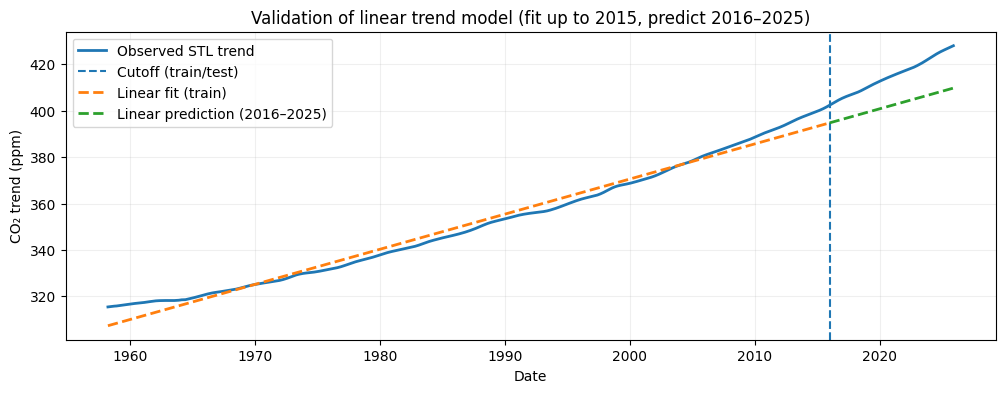

In [40]:
plt.figure(figsize=(12,4))
plt.plot(trend.index, trend.values, linewidth=2, label="Observed STL trend")
plt.axvline(cutoff, linestyle="--", label="Cutoff (train/test)")

yhat_train = a + b * (t_train - t0)
plt.plot(train.index, yhat_train, linestyle="--", linewidth=2, label="Linear fit (train)")

plt.plot(test.index, yhat_test, linestyle="--", linewidth=2, label="Linear prediction (2016–2025)")

plt.title("Validation of linear trend model (fit up to 2015, predict 2016–2025)")
plt.xlabel("Date")
plt.ylabel("CO₂ trend (ppm)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

Fitting the linear trend only up to 2015 and predicting 2016–2025 underestimates the observed STL trend, leading to large errors (**MAE ≈ 12.7 ppm, RMSE ≈ 13.0 ppm**), which indicates that the CO₂ growth rate increased after 2015 and that a constant-slope linear model is not adequate for reliable forecasting over this period.

### Conclusion
To conclude, the analysis of the Mauna Loa weekly data revealed that the CO₂ concentration record can be well described as the sum of an increasing long-term trend and a stable annual seasonal cycle. The STL decomposition effectively isolates these components. The fitted linear model calculates an average growth rate of about 1.66 ppm/year, indicating a global increase but failing to predict recent years accurately. Between 2016 and 2025, the model significantly underestimated observed levels, proving that a constant-slope projection is not sufficient for long-term forecasting.